# Unsupervised Anomaly Detection on fastMRI

### *Run these cells only when in Google Colab*

In [1]:
# # Clone the repository
# !git clone https://github.com/compai-lab/mad_seminar_s23.git
# # Move all content to the current directory
# !mv ./mad_seminar_s23/* ./
# # Remove the empty directory
# !rm -rf mad_seminar_s23/

In [2]:
# # Download the data
# !wget <link you got from your supervisor>
# # Extract the data
# !unzip -q ./data.zip

In [3]:
# # Install additional packages
# !pip install pytorch_lightning --quiet
# !pip install lpips

## Imports

In [4]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml

from model.patchcore.run_patchcore import dataset, run, patch_core, sampler
from model.patchcore.patchcore import PatchCore
from data_loader import TrainDataModule, get_all_test_dataloaders

# autoreload imported modules
%load_ext autoreload
%autoreload 2

C:\Users\asnra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the config

In [5]:
with open('./configs/autoencoder_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config['seed'])

Global seed set to 42


42

## Load and visualize the data

Using 711 IXI images and 130 fastMRI images for training. Using 15 images for validation.
Batch shape: torch.Size([1, 3, 128, 128])
Batch min: 0.0
Batch max: 1.0


TypeError: 'Axes' object is not subscriptable

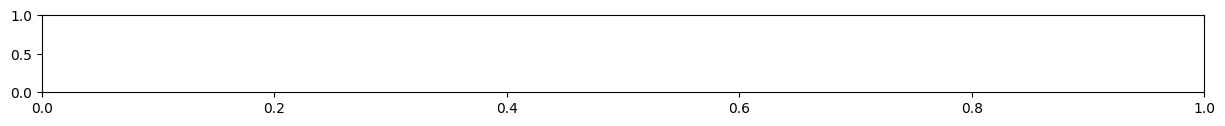

In [6]:
train_data_module = TrainDataModule(
    split_dir=config['split_dir'],
    target_size=config['target_size'],
    batch_size=config['batch_size'])

test_dataloaders = get_all_test_dataloaders(config['split_dir'], config['target_size'], config['batch_size'])

# Plot some images
batch = next(iter(train_data_module.train_dataloader()))

# Print statistics
print(f"Batch shape: {batch.shape}")
print(f"Batch min: {batch.min()}")
print(f"Batch max: {batch.max()}")

img_num = min(5, batch.shape[0])

fig, ax = plt.subplots(1, img_num, figsize=(15, img_num))
for i in range(img_num):
    ax[i].imshow(batch[i].squeeze().permute(1,2,0))
    ax[i].axis('off')
plt.show()

## Prepare model

In [ ]:
# we run the patchcore model

methods ={}
methods["get_dataloaders"] = lambda seed: [{"training": train_data_module,
            "validation": train_data_module,
            "testing": test_dataloaders, 
            "names": [
        'absent_septum',
        'artefacts',
        'craniatomy',
        'dural',
        'ea_mass',
        'edema',
        'encephalomalacia',
        'enlarged_ventricles',
        'intraventricular',
        'lesions',
        'mass',
        'posttreatment',
        'resection',
        'sinus',
        'wml',
        'other'
    ]}]

n1, f1 = sampler('approx_greedy_coreset', 0.1 )
methods[n1] =f1
# we also pick greedy_coreset because that is what PNI paper mentions
# 0.1 is the default value according to documentation
n2, f2 =patch_core(["wideresnet50"], ['layer2', 'layer3'], 1024, 1024, "mean", "mean", 5, 3, "max", 0.0, [], True, 8)
methods[n2] = f2
# rest of values are just default 


results_path = r"D:\D_Coding\Coding\PNI_Medical_Anomaly\results"
# make sure gpus is correctly used
gpu_ids = [0]
seed = config["seed"]
log_group = "group"
log_project = "project"
save_segmentation_images = True
save_patchcore_model = False


run(methods, results_path, gpu_ids, seed, log_group, log_project, save_segmentation_images, save_patchcore_model)

## Run training

## Evaluation

In [ ]:
# Reconstructions from the validation set
batch = next(iter(train_data_module.val_dataloader()))

with torch.inference_mode():
    results = model.detect_anomaly(batch)
    reconstructions = results['reconstruction']

# Plot images and reconstructions
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(5):
    ax[0][i].imshow(batch[i].squeeze(), cmap='gray')
    ax[0][i].axis('off')
    ax[1][i].imshow(reconstructions[i].squeeze(), cmap='gray')
    ax[1][i].axis('off')

## Visualize pathology and labels

In [ ]:
# Get test dataloaders
test_dataloaders = get_all_test_dataloaders(config['split_dir'], config['target_size'], config['batch_size'])

In [ ]:
diseases = ['absent_septum', 'edema', 'enlarged_ventricles', 'mass', 'dural']
fig, ax = plt.subplots(3, len(diseases), figsize=(15, 5))
for i in range(len(diseases)):
    batch = next(iter(test_dataloaders[diseases[i]]))
    inputs, pos_labels, neg_masks = batch
    ax[0][i].imshow(inputs[i].squeeze(), cmap='gray')
    ax[0][i].axis('off')
    ax[1][i].imshow(pos_labels[i].squeeze(), cmap='gray')
    ax[1][i].axis('off')
    ax[2][i].imshow(neg_masks[i].squeeze(), cmap='gray')
    ax[2][i].axis('off')
    ax[0][i].set_title(diseases[i])

In [ ]:
from evaluate import Evaluator 

evaluator = Evaluator(model, model.device, test_dataloaders)

metrics, fig_metrics, fig_example = evaluator.evaluate()

In [ ]:
fig_metrics.keys()

In [ ]:
fig_metrics['F1']

In [ ]:
fig_example